In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [87]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARIMA',FutureWarning)

In [4]:
from get_data import get_data

In [180]:
df= get_data('WEAT', '2009-1-1', '2023-1-1', interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [97]:
df.shape

(135, 5)

We'll check the stationarity of the time series

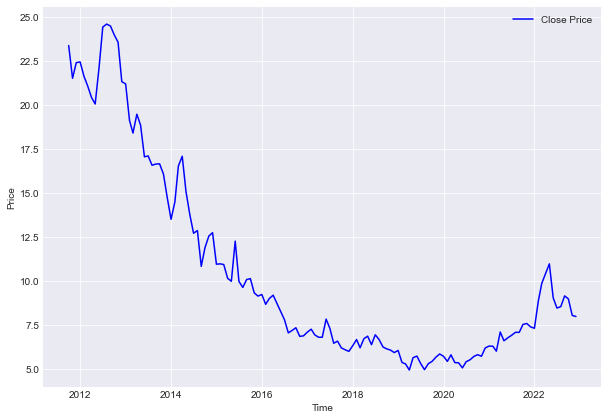

In [76]:
#first lets check it visually
plt.figure(figsize=(10, 7))
plt.plot(df.close, 'b', label='Close Price')
plt.xlabel('Time'); plt.ylabel('Price') 
plt.legend()

Clearly the price is not stationary

In [69]:
#now lets verify our hypothysis by ADF test, null hypothysis being the series is non-stationary
# if the p value is less than .05, we'll reject the null hypothysis and conclude that the series is stationary

from statsmodels.tsa.stattools import adfuller

#adfuller returns a tuple where the 2nd value(index 1) is the p-value)
result= adfuller(df.close)[1]
print('stationary') if result <.05 else print('non-stationary')

non-stationary


As the series is non stationary, we'll perrorm first order differencing on the series to convert it into a stationary series

Text(0.5, 1.0, 'First Order Differenced Series')

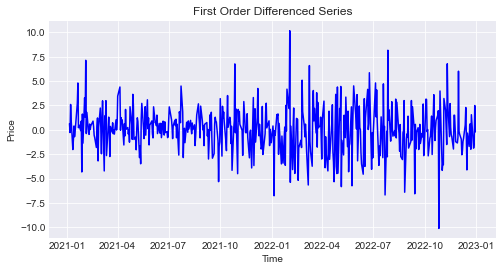

In [181]:
close_diff= df.close.diff().dropna()

plt.figure(figsize=(8, 4))
plt.plot(stationary, 'b',)
plt.xlabel('Time'); plt.ylabel('Price') 
plt.title('First Order Differenced Series')

Lets check if the series is stationary now using the adfuller test

In [182]:
result= adfuller(close_diff)[1]
print('stationary') if result <.05 else print('non-stationary')

stationary


Now that the series is stationary, we know the d = 1 in ARIMA(p,d,q), Lets find out p and by plotting acf and  pacf plots

We'll test our model using the rolling function since the data is continious in nature. We'll define a rolling window which will also be used to slice the data for testing


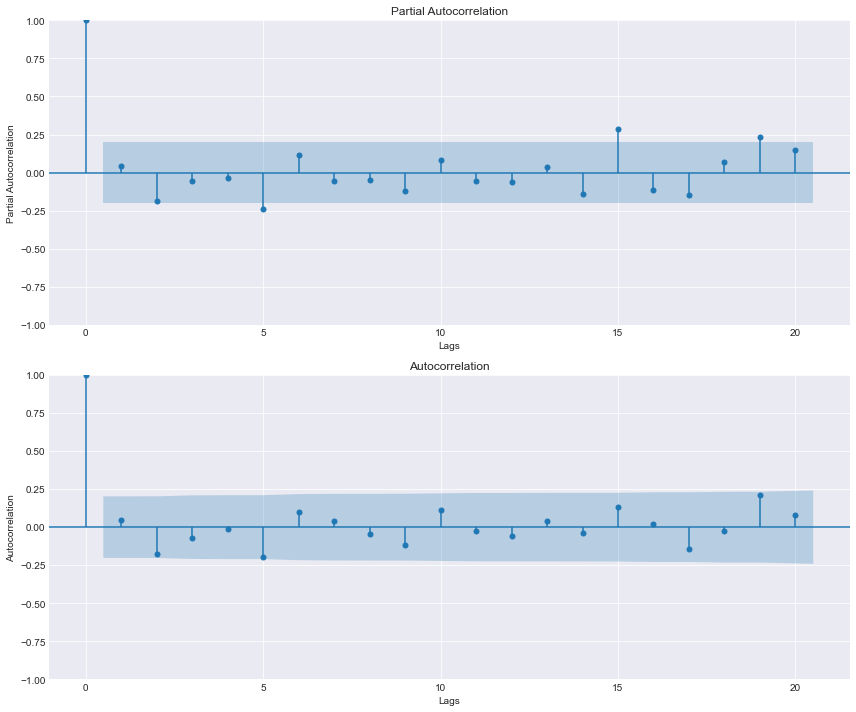

In [183]:
rolling_window= int(len(df)*.7)
data= df.close.diff().dropna()[:rolling_window]
                               
fig, (ax1,ax2)= plt.subplots(2,1, figsize= (12,10))

plot_pacf(data, lags=20, ax= ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

plot_acf(data,lags=20,ax= ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')
                               
plt.tight_layout()
plt.show()                               

From the above plot we can see that pacf is significant at 5th lag, so our AR will be of order 5 i.e. p=5 in our model whereas the acf plot tells us that it's not significant at any lag thus our MA will be of order 0 i.e. q = 0 in ARIMA(p,d,q).

In [80]:
from statsmodels.tsa.arima.model import ARIMA

In [104]:
date_index = pd.date_range(start=df.index[0], end=df.index[-1], freq='MS')
ts = pd.Series(df['close'].values, index=date_index)

In [187]:
model_0= ARIMA(ts[:rolling_window], order=(5,1,0)).fit()
params= model_0.params

In [188]:
def predict_price_arima(train_data):
    
    model= ARIMA(train_data,order=(5,1,0)).fit(start_params= params)
    
    return model.forecast()

In [189]:
df['predicted_price']= ts.rolling(rolling_window).apply(predict_price_arima)
df.predicted_price= df.predicted_price.shift(1)

Evaluating the Model

In [190]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [191]:
print(f'MSE:{mse(df.close[rolling_window:],df.predicted_price[rolling_window:]).round(2)}')
print(f'MAE:{mae(df.close[rolling_window:],df.predicted_price[rolling_window:]).round(2)}')

residuals = df.close - df.predicted_price
mape= 100* (residuals[rolling_window:]/df.close[rolling_window:]).abs().mean()
print(f'MAPE: {np.round(mape,2)}')

MSE:0.39
MAE:0.42
MAPE: 5.65


We are getting more than 5% MAPE so out model is not good, but optimal

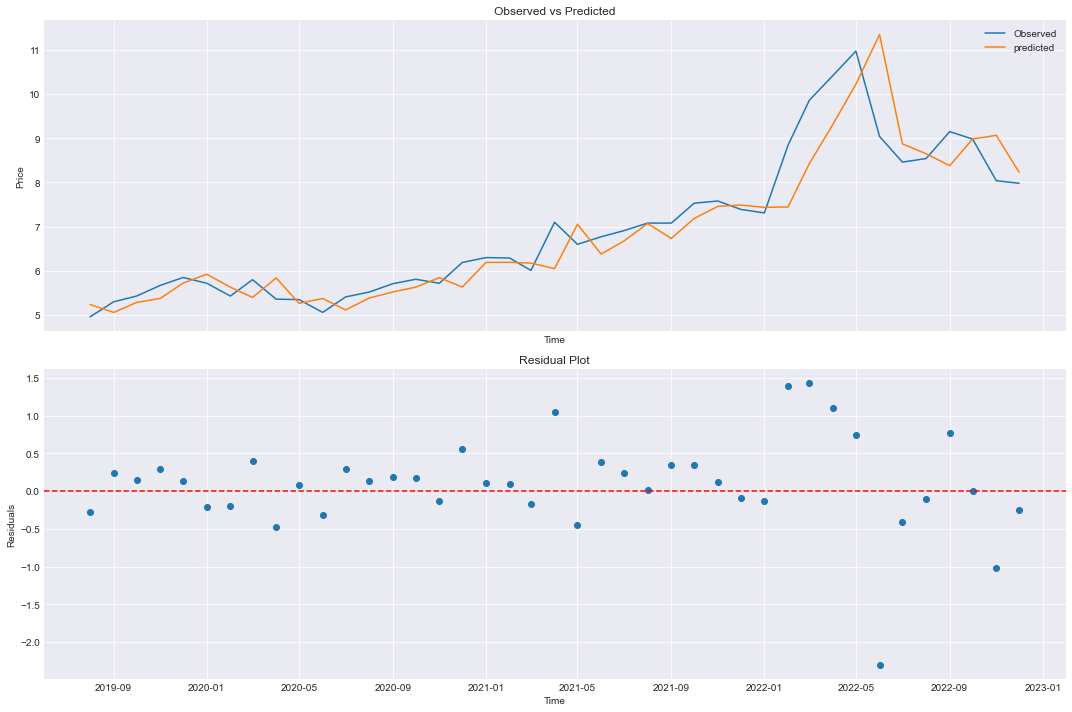

In [192]:
fig,(ax3,ax4) = plt.subplots(2,1, figsize=(15,10), sharex=True)

ax3.plot(df.close[rolling_window:], label= 'Observed')
ax3.plot(df.predicted_price[rolling_window:], label='predicted')
ax3.set_title('Observed vs Predicted')
ax3.legend(loc=0)
ax3.set_xlabel('Time')
ax3.set_ylabel('Price')
               
               
residuals = df.close - df.predicted_price
ax4.scatter(df.index[rolling_window:], residuals[rolling_window:])
ax4.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
ax4.set_title('Residual Plot')
ax4.set_xlabel('Time')
ax4.set_ylabel('Residuals')


plt.tight_layout()
plt.show()